### **Waze Retention and Churning Analysis**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Regression and data modelling libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

pd.set_option('display.max_columns', None)

In [2]:
# Load dataset into dataframe
df = pd.read_csv('waze_dataset.csv')

# Backup dataset with original unmodified data
df0 = df

As seen earlier, 82.3% of users were retained. This section will delve further into how each group differs and will identify factors that affect retention rate.

First, we engineer some features for our analysis and machine learning models.

#### **Feature Engineering**

In [3]:
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
median_km_per_drive = df.groupby('label').median(numeric_only=True)[['km_per_drive']]
median_km_per_drive

,km_per_drive
label,
churned,74.109416
retained,75.014702


In [4]:
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [5]:
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

The median user drive around the same distance for each drive whether they are retained or churned.

In [6]:
# Add km per driving day
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
median_km_per_driving_day = df.groupby('label').median(numeric_only=True)[['km_per_driving_day']]
median_km_per_driving_day

,km_per_driving_day
label,
churned,697.541999
retained,289.549333


In [7]:
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [8]:
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

The median churned user drives significantly more in a driving day than a retained user.

In [9]:
# Add drives per driving day
df['drives_per_driving_day'] = df['drives'] / df['driving_days']
median_drives_per_driving_day = df.groupby('label').median(numeric_only=True)[['drives_per_driving_day']]
median_drives_per_driving_day

,drives_per_driving_day
label,
churned,10.0000
retained,4.0625


In [10]:
df['drives_per_driving_day'].describe()

count    1.499200e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.800000e+00
50%      4.666667e+00
75%      1.216667e+01
max               inf
Name: drives_per_driving_day, dtype: float64

In [11]:
df.loc[df['drives_per_driving_day']==np.inf, 'drives_per_driving_day'] = 0
df['drives_per_driving_day'].describe()

count    14992.000000
mean         9.387368
std         19.826097
min          0.000000
25%          1.250000
50%          3.666667
75%          9.000000
max        395.000000
Name: drives_per_driving_day, dtype: float64

In [12]:
# A professional driver determined somewhat arbitrarily
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [13]:
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [14]:
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [15]:
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

In [16]:
df['percent_of_drives_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14999 non-null  int64  
 1   label                           14299 non-null  object 
 2   sessions                        14999 non-null  int64  
 3   drives                          14999 non-null  int64  
 4   total_sessions                  14999 non-null  float64
 5   n_days_after_onboarding         14999 non-null  int64  
 6   total_navigations_fav1          14999 non-null  int64  
 7   total_navigations_fav2          14999 non-null  int64  
 8   driven_km_drives                14999 non-null  float64
 9   duration_minutes_drives         14999 non-null  float64
 10  activity_days                   14999 non-null  int64  
 11  driving_days                    14999 non-null  int64  
 12  device                          

Less than 1% of rows have null objects, from EDA this is assumed to be due to random error. Therefore, we will remove these rows to finish the feature engineering.

In [18]:
# Dropping rows with N/A
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14292 entries, 0 to 14998
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14292 non-null  int64  
 1   label                           14292 non-null  object 
 2   sessions                        14292 non-null  int64  
 3   drives                          14292 non-null  int64  
 4   total_sessions                  14292 non-null  float64
 5   n_days_after_onboarding         14292 non-null  int64  
 6   total_navigations_fav1          14292 non-null  int64  
 7   total_navigations_fav2          14292 non-null  int64  
 8   driven_km_drives                14292 non-null  float64
 9   duration_minutes_drives         14292 non-null  float64
 10  activity_days                   14292 non-null  int64  
 11  driving_days                    14292 non-null  int64  
 12  device                          

In [19]:
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_drive,km_per_driving_day,drives_per_driving_day,professional_driver,percent_sessions_in_last_month,total_sessions_per_day,km_per_hour,percent_of_drives_to_favorite
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,11.632058,138.360267,11.894737,1,0.953670,0.130381,79.430298,0.700931
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,128.186173,1246.901868,9.727273,0,0.406856,0.266854,260.389902,0.253903
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,32.201567,382.393602,11.875000,0,0.841186,0.051121,113.953460,0.000000
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,22.839778,304.530374,13.333333,0,0.724968,4.505948,93.351141,4.867640
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,58.091206,219.455667,3.777778,1,0.499266,0.107713,194.342970,1.016363
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,8.749890,81.930791,9.363636,0,0.404229,0.106009,123.147688,0.000000
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,2624.586414,228.224906,0.086957,0,0.012673,0.657570,433.471306,0.857534
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,225.487213,394.602623,1.750000,0,0.221499,0.058711,191.944326,0.000000
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,57.645864,132.585488,2.300000,0,0.310573,0.432859,99.791944,0.141665
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,88.874416,2014.486765,22.666667,0,0.343134,0.081682,154.838864,0.294115


#### **Engineered Features EDA**

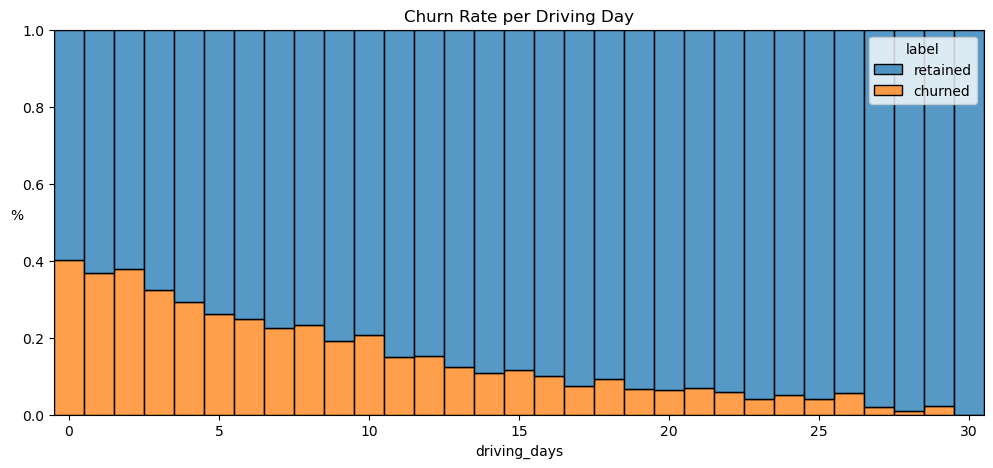

In [20]:
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Churn Rate per Driving Day');

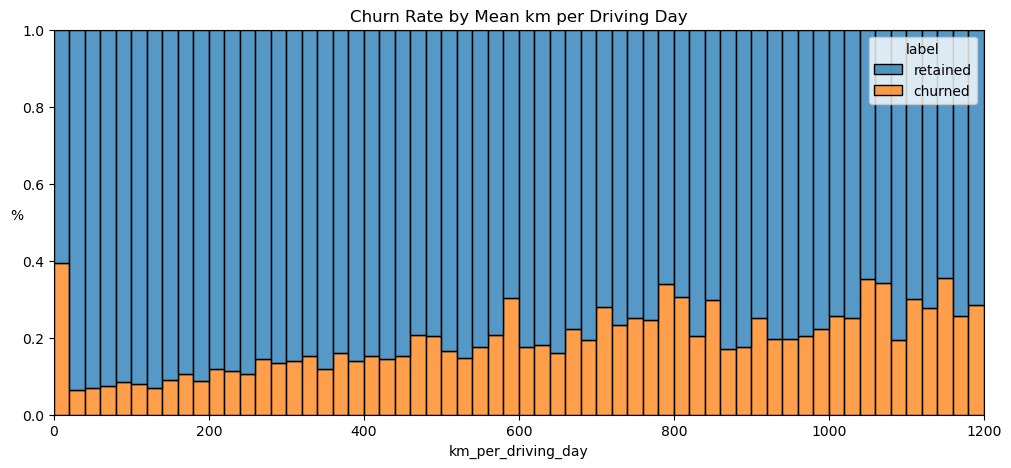

In [21]:
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='km_per_driving_day',
             bins=range(0,1201,20), # Limit km per driving day to 1200 km
             hue='label',
             multiple='fill')
plt.ylabel('%', rotation=0)
plt.title('Churn Rate by Mean km per Driving Day');

The first produced histogram suggests that if a user has more driving days they are more likely to be retained. However, the second histogram shows that if a user drives more in an average day, they are more likely to churn.

#### **Device Usage Hypothesis Testing**
Is there a statistically significant difference between the average number of drives for each device type?

In [22]:
# Map device types for hypothesis testing
map_dict = {'iPhone': 1, 'Android': 2}

df['device_type'] = df['device']
df['device_type'] = df['device_type'].map(map_dict)

df['device_type'].head(10)

C:\Users\oskar\AppData\Local\Temp\ipykernel_11036\1327813152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device_type'] = df['device']
C:\Users\oskar\AppData\Local\Temp\ipykernel_11036\1327813152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device_type'] = df['device_type'].map(map_dict)


0    2
1    1
2    2
3    1
4    2
5    1
6    1
7    1
8    2
9    1
Name: device_type, dtype: int64

In [23]:
df.groupby('device_type')['drives'].mean()

device_type
1    67.955324
2    66.076331
Name: drives, dtype: float64

The mean drives per device is close, with iPhone having a slightly higher average. However, this difference can arise from random sampling rather than being a real difference. To assess if this difference is statistically significant, a two-sample t-test will be conducted.

Hypotheses:

$H_0$: There is no difference in average number of drives between drivers who use iPhone devices and drivers who use Androids.

$H_A$: There is a difference in average number of drives between drivers who use iPhone devices and drivers who use Androids.


Significance level is 5%

In [24]:
# Isolate drives columns for each device
iphone = df[df['device_type'] == 1]['drives']
android = df[df['device_type'] == 2]['drives']

# T-test
stats.ttest_ind(a=iphone, b=android, equal_var=False)

Ttest_indResult(statistic=1.649774209214806, pvalue=0.09901815978424397)

P-value is 16%, which is higher than the significance level of 5%. Therefore, there is no statistically significant difference in the average number of drives between drivers of each device type. 

Device type is not a factor in drives (usage), but does it affect the retention rate of the user?

#### **Device Retention**

Is there a difference between the retention rates for each device type?

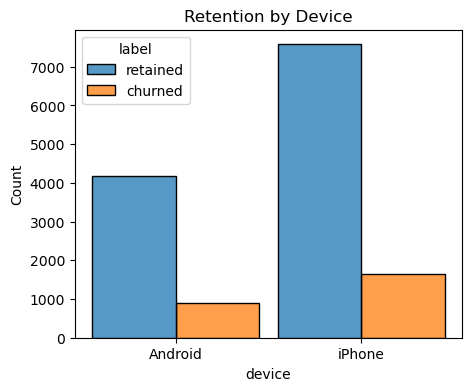

In [25]:
plt.figure(figsize=(5,4))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Retention by Device');

In [26]:
df['device'].value_counts(normalize=True)

iPhone     0.645256
Android    0.354744
Name: device, dtype: float64

In [27]:
iphone_retention = df[df['device'] == 'iPhone']
android_retention = df[df['device'] == 'Android']

In [28]:
iphone_retention['label'].value_counts(normalize=True)

retained    0.821731
churned     0.178269
Name: label, dtype: float64

In [29]:
android_retention['label'].value_counts(normalize=True)

retained    0.824458
churned     0.175542
Name: label, dtype: float64

The histogram and normalized retention values shows that there is no difference in retention rates between device types. Therefore, the type of device that the user accesses the app on does not affect the usage (drives) and retention rate.

We can continue to check each feature to see how it affects retention rate, however, this does not take into account how all features affect retention rate with different weighting. To simplify this process, a XGBoost model will be build and the feature importance will be exctracted from this model.

#### **Machine Learning for Feature Importance**

In [30]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_drive,km_per_driving_day,drives_per_driving_day,professional_driver,percent_sessions_in_last_month,total_sessions_per_day,km_per_hour,percent_of_drives_to_favorite,device_type
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,11.632058,138.360267,11.894737,1,0.953670,0.130381,79.430298,0.700931,2
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,128.186173,1246.901868,9.727273,0,0.406856,0.266854,260.389902,0.253903,1
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,32.201567,382.393602,11.875000,0,0.841186,0.051121,113.953460,0.000000,2
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,22.839778,304.530374,13.333333,0,0.724968,4.505948,93.351141,4.867640,1
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,58.091206,219.455667,3.777778,1,0.499266,0.107713,194.342970,1.016363,2


In [31]:
df = df.drop('ID', axis=1)
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].head(15)

,label,label2
0,retained,0
1,retained,0
2,retained,0
3,retained,0
4,retained,0
5,retained,0
6,retained,0
7,retained,0
8,retained,0
9,churned,1


In [32]:
# Splitting data into train, test and validation sets
X = df.drop(columns=['label', 'label2', 'device', 'drives_per_driving_day', 'device_type'])

y = df['label2']

# Random State 42 for reproductability
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)

In [33]:
# Checking corrent number of train, validation and test observations
for x in [X_train, X_val, X_test]:
    print(len(x))

8574
2859
2859


In [34]:
# Instantiate random forest classifier
rf = RandomForestClassifier(random_state=42)

In [35]:
# Defining model parameters and scoring criteria
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [36]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 1min 32s
Wall time: 1min 32s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'f1', 'precision', 'recall'})

In [37]:
rf_cv.best_score_

0.12039473684210526

In [38]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [39]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [40]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.432622,0.120395,0.188018,0.815489


Still not the best score, see if it will be improved by XGBoost model

In [41]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

In [42]:
# Defining model parameters and scoring criteria
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [43]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 4min 34s
Wall time: 12.1 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'f1', 'precision', 'recall'})

In [44]:
xgb_cv.best_score_

0.16578947368421051

In [45]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 300}

In [46]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.432622,0.120395,0.188018,0.815489
0,XGB cv,0.396562,0.165789,0.232957,0.807441


In [47]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [48]:
# Get validation scores for RF model and append to table
rf_val_preds = rf_cv.best_estimator_.predict(X_val)
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.432622,0.120395,0.188018,0.815489
0,XGB cv,0.396562,0.165789,0.232957,0.807441
0,RF val,0.483444,0.143984,0.221884,0.820916


In [49]:
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.432622,0.120395,0.188018,0.815489
0,XGB cv,0.396562,0.165789,0.232957,0.807441
0,RF val,0.483444,0.143984,0.221884,0.820916
0,XGB val,0.402062,0.153846,0.222539,0.809374


In [50]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.432622,0.120395,0.188018,0.815489
0,XGB cv,0.396562,0.165789,0.232957,0.807441
0,RF val,0.483444,0.143984,0.221884,0.820916
0,XGB val,0.402062,0.153846,0.222539,0.809374
0,XGB test,0.388350,0.157791,0.224404,0.806576


Validation and test score are close, apart from precision which declined noticably. However, the scores are within an acceptable range.

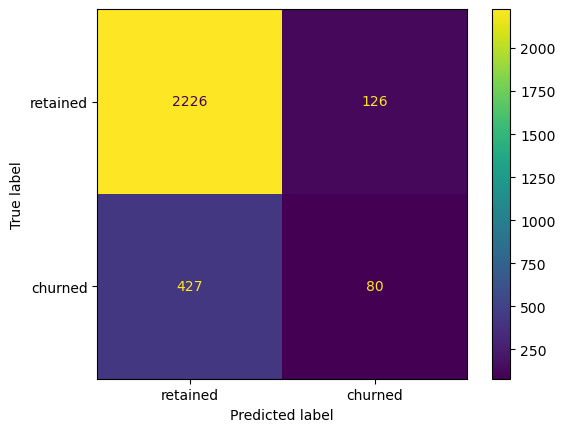

In [51]:
# Plot confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])
disp.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

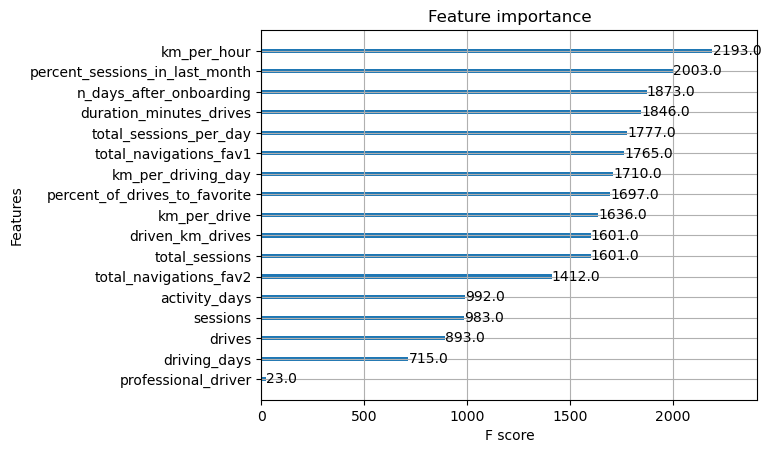

In [52]:
plot_importance(xgb_cv.best_estimator_)

The model shows that kM per hour driven and the percentage of total sessions in the last month are the two key feautures to determine if the user will be retained or churn.

Overall, the model should not be used to make key business due to its low scores across the board, apart from accuracy. The model should be used as a part of the EDA process to understand the importance of certain features in determining the likelyhood of a user churning. 

The feature importance plot shows that the best predictors are engineered predictors, suggesting that the performance of the model can be improved by adding more engineered features.

As the dataset is generated by Waze, not real data, it is likely that the low model scores is due to the fact that the generated data is not based on real observations.